In [1]:
import numpy as np
import pandas as pd
from scipy import sparse as ss
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

In [2]:
#Read the dataframe with reagent pairs
df = pd.read_csv('../data/DRD3/1M_DRD3_pairs.tsv', delimiter='\t')
df

,name_1,smiles_1,name_2,smiles_2,IFP,IFP_polar
0,EN300-7418644_i001,C[C@@H](c1ccc(cc1)C#N)[NH3+],EN300-71903_i001,C1CCN([C@@H](C1)C(=O)[O-])C(=O)C2CCCC2,0.000000,0.0
1,EN300-7418644_i001,C[C@@H](c1ccc(cc1)C#N)[NH3+],EN300-219577_i001,c1c(onc1C(=O)[O-])C[NH+]2CCCC2,0.411765,0.0
2,EN300-7418644_i001,C[C@@H](c1ccc(cc1)C#N)[NH3+],EN300-6830151_i001,c1c(c(no1)C(=O)[O-])C2CC2,0.000000,0.0
3,EN300-7418644_i001,C[C@@H](c1ccc(cc1)C#N)[NH3+],EN300-1601163_i004,C1C[C@@H](C[C@@H]1CC(=O)[O-])O,0.000000,0.0
4,EN300-7418644_i001,C[C@@H](c1ccc(cc1)C#N)[NH3+],EN300-202201_i001,CCCc1c2c(cc(nc2on1)CC)C(=O)[O-],0.500000,0.5
...,...,...,...,...,...,...
999995,EN300-1237271_i001,C1C[NH2+]C[C@@H]1OCC2CC2,EN300-51359_i001,C1C[C@H](Cn2c1nnc2C3CC3)C(=O)[O-],0.000000,0.0
999996,EN300-1237271_i001,C1C[NH2+]C[C@@H]1OCC2CC2,EN300-57589_i003,C[N@H+]1CCC[C@H](C1)C(=O)[O-],0.000000,0.0
999997,EN300-1237271_i001,C1C[NH2+]C[C@@H]1OCC2CC2,EN300-343801_i002,C[C@@H](CCC(=O)[O-])[NH+](C)C,0.000000,0.0
999998,EN300-1237271_i001,C1C[NH2+]C[C@@H]1OCC2CC2,EN300-244267_i001,c1c(c2n(n1)CCC2)C(=O)[O-],0.000000,0.0


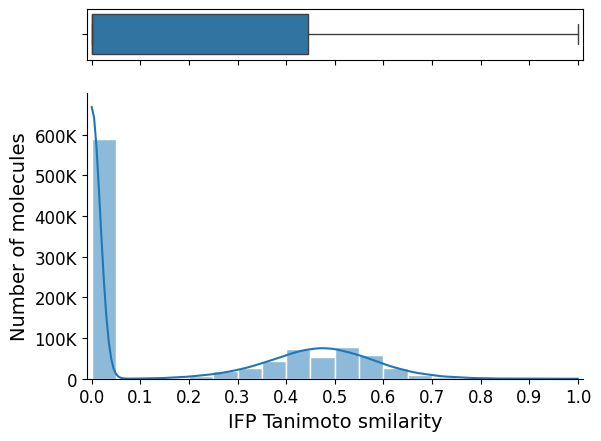

In [3]:
#Plot the distribution of IFP similarity
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.set(style="ticks")

sns.boxplot(data=df['IFP'], orient="h", fliersize=1, ax=ax_box)
plot = sns.histplot(data=df['IFP'], bins=20, kde=True, kde_kws={'bw_adjust':1.15}, ax=ax_hist)
plt.xlim([-0.01,1.01])
plt.yticks([0, 100000, 200000, 300000, 400000, 500000, 600000], ['0', '100K', '200K', '300K', '400K', '500K', '600K'], fontsize = 12)
plt.xticks([i*0.1 for i in range(11)], fontsize = 12)
ax_box.set(xlabel='')
plt.xlabel('IFP Tanimoto smilarity', fontsize=14)
plt.ylabel('Number of molecules', fontsize=14)
plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plt.show()

In [4]:
#Calculate number of hits by thresholds
for q in [0.6, 0.7, 0.8, 0.9]:
    q_polar = 0.5
    df['hit'] = (df['IFP']>=q)&(df['IFP_polar']>=q_polar)
    print(f"Thresholds: IFP={q}; IFP polar= {q_polar}\nNumber of hits: {df['hit'].sum()}")

Thresholds: IFP=0.6; IFP polar= 0.5
Number of hits: 32161
Thresholds: IFP=0.7; IFP polar= 0.5
Number of hits: 7607
Thresholds: IFP=0.8; IFP polar= 0.5
Number of hits: 1335
Thresholds: IFP=0.9; IFP polar= 0.5
Number of hits: 48


## Generate fingerprints 

In [5]:
fp_gen = AllChem.GetMorganGenerator(radius=2, fpSize=2048, includeChirality=True, useBondTypes=True)

In [6]:
#Generate fingerprints for every pair of reagents, convert to sparse matrix and save to disk
row_idx = list()
col_idx = list()

for count, (smi_1, smi_2) in enumerate(tqdm(zip(df['smiles_1'], df['smiles_2']), desc='Generating fingerprints', unit='fp')):

    mol1, mol2 = Chem.MolFromSmiles(smi_1), Chem.MolFromSmiles(smi_2) 
    fp1, fp2 = fp_gen.GetFingerprint(mol1), fp_gen.GetFingerprint(mol2)

    fp_and = fp1 & fp2
    fp_xor = fp1 ^ fp2
    fp = fp_and + fp_xor

    onbits = list(fp.GetOnBits())
    #these bits all have the same row:
    row_idx += [count]*len(onbits)
    #and the column indices of those bits:
    col_idx+=onbits

#generate a sparse matrix out of the row,col indices:
fingerprint_matrix = ss.coo_matrix((np.ones(len(row_idx)).astype(bool), (row_idx, col_idx)), shape=(max(row_idx)+1, 4096))
#convert to csr matrix:
fingerprint_matrix =  ss.csr_matrix(fingerprint_matrix)
#Save fingerprints as sparse matrix
#ss.save_npz('../data/DRD3/1M_DRD3_fingerprints.npz', fingerprint_matrix)

Generating fingerprints: 1000000fp [09:30, 1753.61fp/s]


## Generate training labels

In [7]:
#Set thresholds of IFP similarity
q = 0.6
q_polar = 0.5

In [8]:
#Create np array with training labels for each pair: hit - '1', else - '0'
y = np.where(((df['IFP'] >= q) & (df['IFP_polar']>=q_polar)), 1, 0)
#Save labels as np array
#np.save('../data/DRD3/1M_DRD3_labels.npy', y)